# Regresión lineal y logística

*Este notebook es Modificado a partir de [ageron](https://github.com/ageron/handson-ml2)*

## Configuración

En seguida se cargan las librerías necesarias para el desarrollo de este notebook y algunos parámetros de configuración

In [ ]:
import sklearn      # Sirve para realizar modelos
import numpy as np  # Para manejo algebraico: matrices, operaciones, aleaotorios

# Esto es para que los resultados sean comunes en todos los notebooks
np.random.seed(42)

# Menejo de gráficos
%matplotlib inline
import matplotlib as mpl        # Para manejo grafico
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignorar algunos warnings innecesarios
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Regresión lineal usando las ecuaciones normales

En seguida se crean datos hipotéticos que se asocian linealmente.

In [ ]:
m = 100 # Cantidad de ejemplos
X = 2 * np.random.rand(m, 1)  # Se crean 100 numeros aleatorios entre 0 y 2
y = 4 + 3 * X + np.random.randn(m, 1)

Observe los resultados en seguida

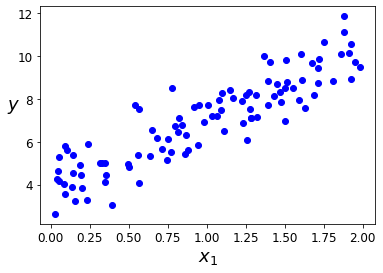

In [ ]:
plt.plot(X, y, "bo") # puntos azules (b), bolitas (o)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.show()

Como puede ver los datos parecen estar asociados linealmente, un buen modelo podría ser el siguiente:

$$\hat{y}^{(j)} = \theta_0 + \theta_1 x^{(j)}$$

Que es lo mismo a:

$$\left(\begin{array}{c}y^{(1)}\\y^{(2)}\\\vdots\\ y^{(m)}\end{array}\right) = \left(\begin{array}{cc}1 & x^{(1)}\\1 & x^{(2)}\\\vdots & \vdots\\ 1 & x^{(m)}\end{array}\right)\left(\begin{array}{c}\theta_0\\\theta_1\end{array}\right)$$

O en una manera más compacta:

$$\hat{y} = X_b\theta$$

Entonces, se conforma la matriz de entrada $X$, agregando unos en la primer columna y se encuentran los mejores parámetros del modelo que minimicen los errores cuadrados, mediante la **ecuación normal**.

$$\hat{\theta} = \underbrace{\left(X_b'X_b\right)^{-1}}_{a}\underbrace{X_b'y}_{b}$$


In [ ]:
unos = np.ones((m,1)) # matriz de unos
X_b = np.c_[unos, X]  # Concateno la matriz de unos con X

In [ ]:
X_T = X_b.T             # Calcula la transpuesta de X_b
b = np.dot(X_T, y)      # Producto entre X transpuesta e y
XTX = np.dot(X_T, X_b)  # Producto entre X transpuesta y X
a = np.linalg.inv(XTX)  # Inversa del cálculo anterior

theta = np.dot(a,b)     # Encuentra theta (intercepto y pendiente)
theta

array([[3.88768424],
       [3.15357999]])

Ahora realizamos una prueba para verficar el comportamiento del modelo lineal.
$$X_{new} = \left(\begin{array}{c}0\\2\end{array}\right)$$


In [ ]:
Xnew = np.array([[0],
                 [2]])

unos = np.ones((2,1))           # matriz de unos
Xnew_b = np.c_[unos, Xnew]      # Concateno la matriz de unos con Xnew

y_gorro = np.dot(Xnew_b, theta) # pronostico de y
y_gorro

array([[ 3.88768424],
       [10.19484423]])

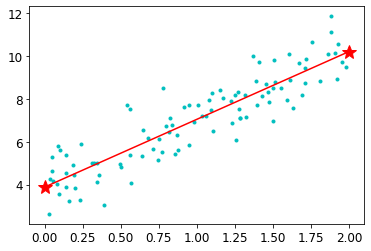

In [ ]:
plt.plot(X, y, '.c')                         # grafica los puntos de color cian
plt.plot(Xnew, y_gorro, '*r', markersize=15) # estrellitas con los datos nuevos
plt.plot(Xnew, y_gorro, 'r')                 # grafica la línea

De una manera más sencilla se utiliza la función `LinearRegression` del paquete `sklearn`

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()        # Paso 1: Se crea el modelo
lin_reg.fit(X, y)                   # Paso 2: Se ajusta
lin_reg.intercept_, lin_reg.coef_   # Paso 3: Obtengo los valores de theta

(array([3.88768424]), array([[3.15357999]]))

In [ ]:
lin_reg.predict(Xnew)

array([[ 3.88768424],
       [10.19484423]])

**Opcional**

La clase `LinearRegression` se basa en la función `scipy.linalg.lstsq()`  ("least squares"), la cual se puede utilizar directamente

In [ ]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

La función evalúa $\mathbf{X}^+\mathbf{y}$, donde $\mathbf{X}^{+}$ es la _pseudoinversa_ de $\mathbf{X}$ (específicamente la inversa _Moore-Penrose_). Si quiere puede usar `np.linalg.pinv()` para calcular la pseudoinversa directamente:

In [ ]:
np.linalg.pinv(X_b).dot(y)

array([[3.88768424],
       [3.15357999]])

## Regresión lineal usando gradiente descendente por lotes (batch gradient descendent)

El método define una función de costo, el cual se debe minimizar y para esto se utiliza su gradiente.

**1 .Función de Costo**

La función de costo permite evaluar el error de la función lineal. Este se define como:

$$J(\theta_0, \theta_1; X, y) = \frac{1}{2m}\sum_{j=1}^{m}(\hat{y}^{(j)}-y^{(j)})^2$$

**2. Gradiente de la función de costo**

Recordemos que el gradiente de una función es la dirección en la que se encuentra el mayor crecimiento de una función. Entonces, si queremos encontrar el mínimo de la función de costo, simplemente iteramos en pasos sucesivos hacia dirección de su gradiente negativo.

En la siguiente imagen se observa el proceso.

![](https://alykhantejani.github.io/images/gradient_descent_line_graph.gif)

Como el costo $J$ depende de $\theta_0$ y $\theta_1$, calculamos su gradiente $\nabla J = (\partial J/\partial\theta_0, \partial J/\partial\theta_1)$. Esto nos dirá la dirección hacia donde el costo aumenta y su valor negativo hacia donde disminuye. Luego, lo multiplicamos por un valor de paso $\alpha$ y actualizamos los valores $\theta_0$ y $\theta_1$,

$$\theta_0 := \theta_0 - \alpha\frac{\partial J}{\partial \theta_0}$$

$$\theta_1 := \theta_1 - \alpha\frac{\partial J}{\partial \theta_1}$$

Teniendo en cuenta la ecuación para $J$, al derivar se tiene que:

$$\theta_0 := \theta_0 - \alpha\frac{1}{m} \sum (\theta_0 + \theta_1x_i - y_i)$$

$$\theta_1 := \theta_1 - \alpha\frac{1}{m} \sum (\theta_0 + \theta_1x^{(j)} - y^{(j)})\cdot x^{(j)}$$

Utilizando la definición de $h$, el par de ecuaciones finalmente queda así:

$$\theta_0 := \theta_0 - \frac{\alpha}{m} \sum (\hat{y}^{(j)}- y^{(j)})$$

$$\theta_1 := \theta_1 - \frac{\alpha}{m} (\hat{y}-y) \cdot X$$

Donde $\cdot$ representa el producto punto entre dos vectores.

O de una manera más compacta:

$$\hat{\theta} = \frac{\alpha}{m}X(\hat{y}-y)$$


In [ ]:
alpha = 0.1  # paso de aprendizaje
n_iterations = 1000
m = len(X_b)

theta = np.random.randn(2,1)  # inicializacion aleatoria

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y) # gradiente del costo
    theta = theta - alpha * gradients               # Se actualizan los thetas

In [ ]:
theta

array([[3.88768424],
       [3.15357999]])

In [ ]:
Xnew_b.dot(theta)

array([[ 3.88768424],
       [10.19484423]])

In [ ]:
theta_path_bgd = []

def plot_gradient_descent(theta, alpha, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = Xnew_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(Xnew, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - alpha * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\alpha = {}$".format(alpha), fontsize=16)

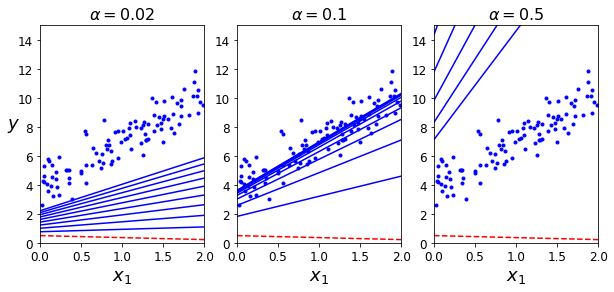

In [ ]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, alpha=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, alpha=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, alpha=0.5)

plt.show()

Observe que si el hiperparámetro $\alpha$ es muy pequeño el aprendizaje es muy lento, pero si es muy grande el aprendizaje se acelera tanto que posiblemente no se termine aprendiendo!

![](https://www.healthychildren.org/SiteCollectionImagesArticleImages/sulky-angry-girl-pouting.jpg?RenditionID=3)

## Gradiente descendente estocástico
En lugar de utilizar todos los ejemplos para calcular los parámetros $\theta$ se utiliza uno a uno. 

**Ventaja**: Este método permite encontrar más fácil el mínimo global.

**Desventaja**: Puede ser muy lenta la búsqueda del mínimo

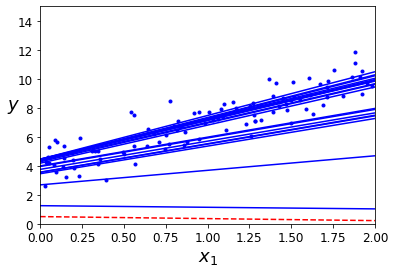

In [ ]:
theta_path_sgd = [] # Aqui se almacenarán el histórico
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # Hiperparámetros para reducir alpha lentamente

# Este método permite reducir alpha lentamente
def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # inicialización aleatoria

for epoch in range(n_epochs):
    for i in range(m):  # Por cada ejemplo se calculan los parametros theta
        if epoch == 0 and i < 20:  # Solo para fines gráficos                
            y_predict = Xnew_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(Xnew, y_predict, style)        

        # Se toma aleatoriamente un ejemplo de los datos
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        alpha = learning_schedule(epoch * m + i)

        # Se calculan los mejores parámetros y se almacenan en el histórico
        theta = theta - alpha * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                                                            
plt.show()                                           

In [ ]:
theta

array([[3.91196402],
       [3.2084757 ]])

`sklearn` tiene la clase `SGDRegressor` que permite aplicar este método de una manera más sencilla

In [ ]:
from sklearn.linear_model import SGDRegressor

# eta0 = alpha inicial (velocidad de parendizaje inicial)

# paso 1: creo modelo
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)

# paso 2: Ajusto
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
# Paso 3: Obtengo los coeficientes
sgd_reg.intercept_, sgd_reg.coef_

(array([3.92434698]), array([3.21320316]))

## Mini-batch gradient descent

Una manera de equilibrar ambos métodos vistos anteriormente es utilizar algunos ejemplos aleatoriamente.



In [ ]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # inicialización aleatoria

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    # Se ordena aleatoriamente la base de datos
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        # Se seleccionan algunos ejemplos aleatoriamente
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        alpha = learning_schedule(t)
        theta = theta - alpha * gradients
        theta_path_mgd.append(theta)

In [ ]:
theta

array([[3.83683354],
       [3.08525094]])

**Comparación de métodos**

In [ ]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

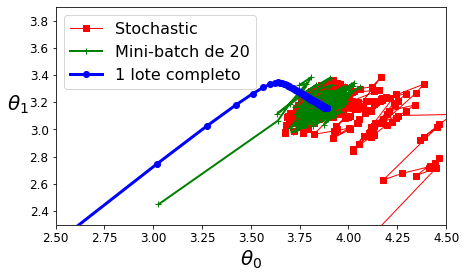

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch de 20")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="1 lote completo")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

## Regresión polinómica




In [ ]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

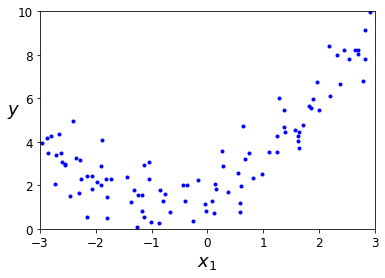

In [ ]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

El paquete `sklearn` tiene la clase `PolynomialFeatures` que permite ajustar los datos a un modelo polinómico

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly[:10,:]

array([[-0.75275929,  0.56664654],
       [ 2.70428584,  7.3131619 ],
       [ 1.39196365,  1.93756281],
       [ 0.59195091,  0.35040587],
       [-2.06388816,  4.25963433],
       [-2.06403288,  4.26023172],
       [-2.65149833,  7.03044338],
       [ 2.19705687,  4.82705891],
       [ 0.60669007,  0.36807284],
       [ 1.24843547,  1.55859111]])

In [ ]:
lin_reg = LinearRegression()      # paso 1: Creo modelo
lin_reg.fit(X_poly, y)            # paso 2: Ajusto
lin_reg.intercept_, lin_reg.coef_ # Paso 3: Observo parámetros

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

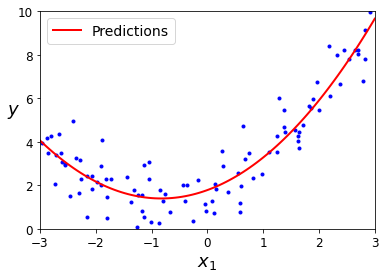

In [ ]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

En seguida vemos ajustes de modelos con diferente grado polinomial

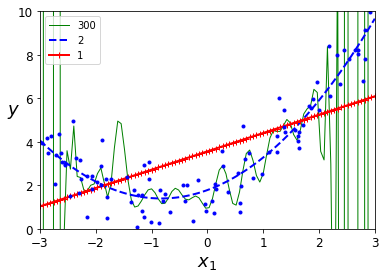

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)    
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

### El problema del sobreajuste

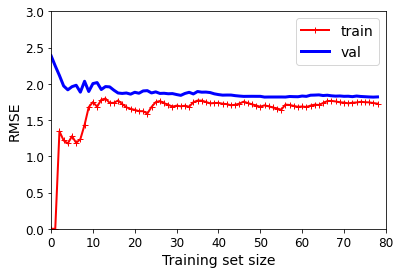

In [ ]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                      
plt.show()                                    

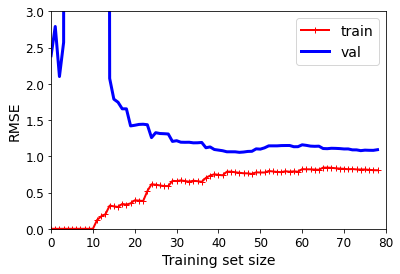

In [ ]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()             

# Regresión logística

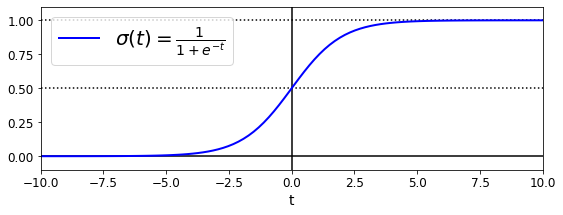

In [ ]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

Se cargan los datos

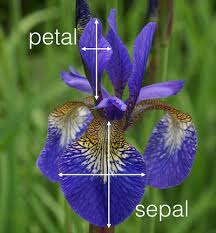

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [ ]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

### Clasificación binomial

La clasificación binomial se realiza utilizando la función sigmoide. Su función de costo y gradiente se definen como:

**Función de costo**:

De manera similar a la función de costo para la regresión lineal, se define la función de costo para la regresión logística.
$$J = -\frac{1}{m} \sum_{i=1}^n [y\cdot \ln(\hat{y})+(1-y)\cdot \ln(1-\hat{y})]$$

Donde:

$$\hat{y} = \frac{1}{1+e^{-X\theta}}$$

**Gradiente de la función de costo**

Recordemos que el gradiente nos dice hacia donde la función de costo debe dirigirse para disminuir para alcanzar el valor mínimo. Calculando el gradiente de la función de costo se obtiene:
$$DJ = -\frac{1}{m}X^T(y-\hat{y})$$

Para empezar se define la entrada y salida $X$ y $y$, respectivamente.

In [ ]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 si es Iris virginica, sino 0

`sklearn` tiene la clase `LogisticRegression` que permite realizar un modelo de regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42) # paso 1: Creo modelo
log_reg.fit(X, y)                                             # paso 2: ajusto

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

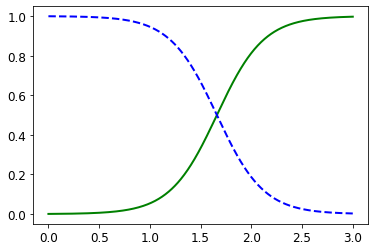

In [ ]:
# paso 3: Observo resultados
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

/usr/local/lib/python3.7/dist-packages/matplotlib/patches.py:1327: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


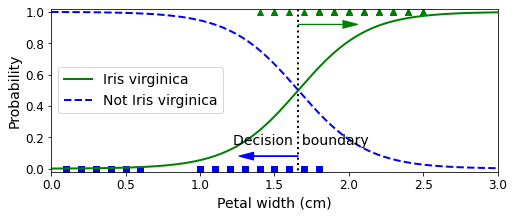

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

La línea de decisión es:

In [ ]:
decision_boundary

array([1.66066066])

Y ahora realicemos algunos pronósticos

In [ ]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

Ahora vamos a incluir otra variable

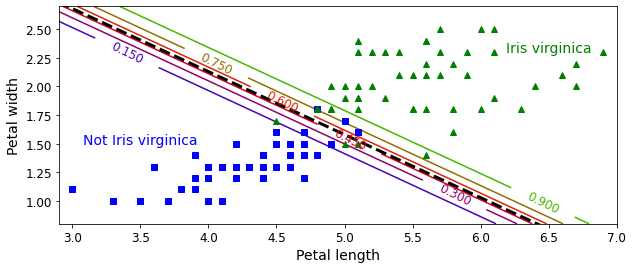

In [ ]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

### Clasificación multinomial
En seguida se realiza una clasificación multinomial de las tres especies de flores

In [ ]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

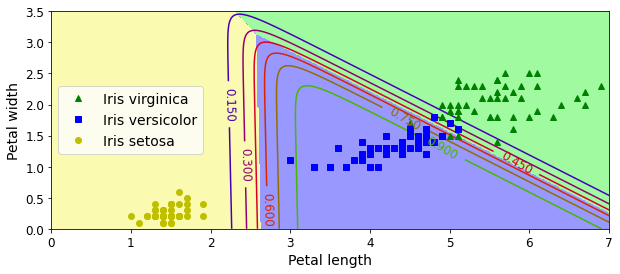

In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [ ]:
softmax_reg.predict([[5, 2]])

array([2])

In [ ]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

## (Opcional) Batch Gradient Descent con frenado automático usando regresión softmax

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [ ]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

We need to add the bias term for every instance ($x_0 = 1$):

In [ ]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

And let's set the random seed so the output of this exercise solution is reproducible:

In [ ]:
np.random.seed(2042)

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but the point of this exercise is to try understand the algorithms by implementing them manually. So here is one possible implementation:

In [ ]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for ay given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance:

In [ ]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

Let's test this function on the first 10 instances:

In [ ]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [ ]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [ ]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [ ]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

We are almost ready to start training. Let's define the number of inputs and outputs:

In [ ]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [ ]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693313
2000 0.5444496861981873
2500 0.5038530181431525
3000 0.4729228972192248
3500 0.4482424418895776
4000 0.4278651093928793
4500 0.41060071429187134
5000 0.3956780375390374


And that's it! The Softmax model is trained. Let's look at the model parameters:

In [ ]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

Let's make predictions for the validation set and check the accuracy score:

In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

Well, this model looks pretty good. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [ ]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629505
1000 0.503640075014894
1500 0.49468910594603216
2000 0.4912968418075477
2500 0.489899247009333
3000 0.48929905984511984
3500 0.48903512443978603
4000 0.4889173621830818
4500 0.4888643337449303
5000 0.4888403120738818


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Cool, perfect accuracy! We probably just got lucky with this validation set, but still, it's pleasant.

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [ ]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109127
1500 0.5355752782580262
2000 0.5331959249285544
2500 0.5325946767399383
2765 0.5325460966791898
2766 0.5325460971327977 early stopping!


In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Still perfect, but faster.

Now let's plot the model's predictions on the whole dataset:

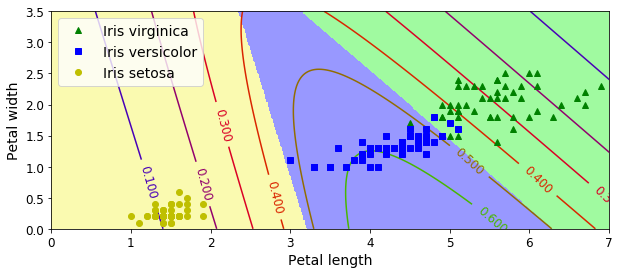

In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

And now let's measure the final model's accuracy on the test set:

In [ ]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

Our perfect model turns out to have slight imperfections. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.